## Bab 17. Interpolasi
MN2023_A2_LK5

#### Initialisation

In [827]:
import numpy as np
import random as rand
from scipy.interpolate import *
import matplotlib.pyplot as plt

In [828]:
# constants
LEN = 4
START = 1

# generation
x = np.arange(START, LEN+START, 1)

y = np.zeros(LEN)
for i in range(len(y)):
    y[i] = rand.randint(1,LEN**2)

X = np.zeros(LEN-1)
for i in range(len(X)):
    X[i] = round(x[i]+rand.random(),2)
    
# X is sorted ascending in value and is one less of x's size so that the values of X are between two values in x.
X.sort()

#### Linear Interpolation

In [829]:
def my_lin_interp(x,y,X):
    Y = [0 for _ in range(LEN-1)]
    for i in range(LEN-1):
        Y[i] = y[i] + ((y[i+1]-y[i]) * (X[i]-x[i]) / (x[i+1]-x[i]))
    return Y

In [830]:
print("x =",x,"; y =",y,"; X =",X)

f = interp1d(x,y)
Y_bench = f(X)
print("scipy =",Y_bench)

Y = my_lin_interp(x,y,X)
print("Y =",Y)

x = [1 2 3 4] ; y = [14.  6. 11. 11.] ; X = [1.81 2.6  3.65]
scipy = [ 7.52  9.   11.  ]
Y = [7.52, 9.0, 11.0]


#### Cubic Spline Interpolation

In [831]:
def findSegment(xData,x):
    iLeft = 0
    iRight = len(xData) - 1
    while 1:
        if (iRight-iLeft) <= 1: return iLeft
        i = int((iLeft + iRight)/2)
        if x < xData[i]: iRight = i
        else: iLeft = i
    return i

In [832]:
# LU decomposition as prerequisite as in Kiusalaas' (2013) Numerical Methods in Engineering with Python 3 p. 62

def LUdecomp3(c,d,e):
    n = len(d)
    for k in range(1,n):
        lam = c[k-1]/d[k-1]
        d[k] = d[k] - lam*e[k-1]
        c[k-1] = lam
    return c,d,e

def LUsolve3(c,d,e,b):
    n = len(d)
    for k in range(1,n):
        b[k] = b[k] - c[k-1]*b[k-1]
        b[n-1] = b[n-1]/d[n-1]
    for k in range(n-2,-1,-1):
        b[k] = (b[k] - e[k]*b[k+1])/d[k]
    return b

In [833]:
def curvatures(x,y): # from Kiusalaas (2013) p. 122
    n = len(x) - 1
    c = np.zeros(n)
    d = np.ones(n+1)
    e = np.zeros(n)
    k = np.zeros(n+1)

    c[0:n-1] = x[0:n-1] - x[1:n]
    d[1:n] = 2.0*(x[0:n-1] - x[2:n+1])
    e[1:n] = x[1:n] - x[2:n+1]
    k[1:n] = 6.0*(y[0:n-1] - y[1:n]) / (x[0:n-1] - x[1:n]) - 6.0*(y[1:n] - y[2:n+1]) / (x[1:n] - x[2:n+1])
    
    p,q,r = LUdecomp3(c,d,e)
    res = LUsolve3(p,q,r,k)
    return res

def kiusalaas_cubic_spline(x,y,X): # adapted for multiple X inpute from Kuisalaas (2013) p. 123
    Y = [0 for _ in range(len(X))]
    k = curvatures(x,y)
    # print("k =",k)
    for j in range(len(X)):
        i = findSegment(x,X[j])
        h = x[i] - x[i+1]
        Y = ((X - x[i+1])**3/h - (X - x[i+1])*h)*k[i]/6.0 - ((X - x[i])**3/h - (X - x[i])*h)*k[i+1]/6.0 + (y[i]*(X - x[i+1]) - y[i+1]*(X - x[i]))/h
    return Y

In [834]:
def my_cubic_spline(x,y,X):
    Y = kiusalaas_cubic_spline(x,y,X)
    return Y

In [835]:
# as reference
def gpt_cubic_spline(x, y, X):
    n = len(x)
    h = np.diff(x)
    a = y[:-1]
    b = np.zeros(n - 2)
    d = np.zeros(n - 2)
    
    for i in range(n - 2):
        b[i] = 6 * ((y[i + 2] - 2 * y[i + 1] + y[i]) / h[i + 1] - (y[i + 1] - y[i]) / h[i])
    
    # Solve for c using tridiagonal matrix algorithm
    l = np.zeros(n - 2)
    u = np.zeros(n - 2)
    z = np.zeros(n - 2)
    l[0] = 2 * (h[0] + h[1])
    u[0] = 0.5
    z[0] = b[0] / l[0]

    for i in range(1, n - 2):
        l[i] = 2 * (h[i] + h[i + 1]) - h[i] * u[i - 1]
        u[i] = h[i + 1] / l[i]
        z[i] = (b[i] - h[i] * z[i - 1]) / l[i]

    c = np.zeros(n)
    c[0] = 0
    c[n - 1] = 0

    for j in range(n - 3, -1, -1):
        c[j + 1] = z[j] - u[j] * c[j + 2]

    # Calculate coefficients for the cubic spline
    b = (y[1:] - y[:-1]) / h - h * (c[:-1] + 2 * c[1:]) / 6
    d = (c[1:] - c[:-1]) / (6 * h)

    # Perform cubic spline interpolation for the given values in X
    Y = np.empty(len(X))

    for i, xi in enumerate(X):
        j = 0
        for k in range(1, n):
            if xi <= x[k]:
                j = k
                break
        j -= 1
        dx = xi - x[j]
        Y[i] = a[j] + b[j] * dx + c[j] * dx ** 2 + d[j] * dx ** 3

    return Y

In [836]:
# x = np.array([1,2,3,4,5,6,7,8,9,10])
# y = np.array([0,1,0,1,0,1,0,1,0,1])
# X = np.array([1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5])
# x = np.array([0,1,2])
# y = np.array([1,3,2])
# X = np.array([0.5,1.5])

print("x =",x,"; y =",y,"; X =",X)

# benchmark
f = interp1d(x, y, kind='cubic')
Y_bench = f(X)
print("Y_scipy =",Y_bench)

Y = my_cubic_spline(x,y,X)
print("Y =",Y)

x = [1 2 3 4] ; y = [14.  6. 11. 11.] ; X = [1.81 2.6  3.65]
Y_scipy = [ 5.970227  8.592    12.694875]
Y = [-7.2896098  8.0432    11.675675 ]


#### Nearest Neighbor Interpolation

In [837]:
def my_nearest_neighbor(x, y, X):
    Y = np.zeros_like(X)
    
    for i, xi in enumerate(X):
        # Find the index j of the nearest neighbor in x
        j = np.argmin(np.abs(x - xi))
        
        # Assign the corresponding y value to Y[i]
        Y[i] = y[j]
    
    return Y

In [838]:
print("x =",x,"; y =",y,"; X =",X)

f = interp1d(x,y)
Y_bench = f(X)
print("scipy =",Y_bench)

Y = my_nearest_neighbor(x,y,X)
print("Y =",Y)

x = [1 2 3 4] ; y = [14.  6. 11. 11.] ; X = [1.81 2.6  3.65]
scipy = [ 7.52  9.   11.  ]
Y = [ 6. 11. 11.]


#### Flat Cubic Spline Interpolation

In [839]:
def my_cubic_spline_flat(x,y,X):
    
    # constraint 1 @ n-1 equations; if option='flat', set eq. = 0
    con_1 = np.zeros((LEN-1,4*(LEN-1)))
    k = 0
    for i in range(LEN-1):
        con_1[i,k] = x[i]**3; k+=1
        con_1[i,k] = x[i]**2; k+=1
        con_1[i,k] = x[i] ;k+=1
        con_1[i,k] = 1 ;k+=1
    # print("con_1",con_1)

    # constraint 2 @ n-1 equations; if option='flat', set eq. = 0
    con_2 = np.zeros((LEN-1,4*(LEN-1)))
    k = 0
    for i in range(1,LEN):
        con_2[i-1,k] = x[i]**3; k+=1
        con_2[i-1,k] = x[i]**2; k+=1
        con_2[i-1,k] = x[i]; k+=1
        con_2[i-1,k] = 1; k+=1
    # print("con_2",con_2)

    # constraint 3 @ n-2 equations
    con_3 = np.zeros((LEN-2,4*(LEN-1)))
    k = 0
    for i in range(1,LEN-1):
        con_3[i-1,k] = 3*x[i]**2; k+=1
        con_3[i-1,k] = 2*x[i]; k+=1
        con_3[i-1,k] = 1; k+=1
        con_3[i-1,k] = 0; k+=1
        con_3[i-1,k] = -1*3*x[i]**2; k+=1
        con_3[i-1,k] = -1*2*x[i]; k+=1
        con_3[i-1,k] = -1*1; k+=1
        con_3[i-1,k] = 0; k-=4
    # print("con_3",con_3)

    # constraint 4 @ n-2 equations
    con_4 = np.zeros((LEN-2,4*(LEN-1)))
    k = 0
    for i in range(1,LEN-1):
        con_4[i-1,k] = 6*x[i]; k+=1
        con_4[i-1,k] = 2*1; k+=1
        con_4[i-1,k] = 0; k+=1
        con_4[i-1,k] = 0; k+=1
        con_4[i-1,k] = -1*6*x[i]; k+=1
        con_4[i-1,k] = -1*2*1; k+=1
        con_4[i-1,k] = 0; k+=1
        con_4[i-1,k] = 0; k-=4
    # print("con_4",con_4)

    # constraint 5 @ 2 equations
    minim = np.zeros(4*(LEN-1)) # index 1
    maxim = np.zeros(4*(LEN-1)) # index n-1
    minim[0] = 6*x[0]
    minim[1] = 2
    maxim[4*(LEN-1)-4] = 6*x[LEN-1]
    maxim[4*(LEN-1)-4 +1] = 2
    # print("minim",minim)
    # print("maxim",maxim)

    # aggregate
    minmax = np.vstack((minim,maxim))
    A = np.vstack((con_1,con_2,con_3,con_4,minmax))
    B = np.zeros(4*(LEN-1))
    y_new = []
    for i in range((LEN-1)):
        for j in range(i,2+i):
            y_new.append(y[j])
    for i in range(len(y_new)):
        B[i] = y_new[i]

    # <A,x> = B => x = <A.inv,B>
    print("A=",A)    
    coeff = np.dot(np.linalg.inv(A),B)

    print("B=",B)    
    print("coeff=",coeff)

    # reshape coeff
    coeff_2 = np.zeros((LEN-1,4))
    k = 0
    for i in range(LEN-1):
        for j in range(4):
            coeff_2[i,j] = coeff[k]; k+=1
    # print("coeff_2",coeff_2)

    # evaluate for all X
    Y = np.zeros(LEN-1)
    for j in range(LEN-1):
        i = findSegment(x,X[j])
        ax = X[i]**3
        bx = X[i]**2
        cx = X[i]
        dx = 1
        X_op = np.array([ax,bx,cx,dx])
        # print("X_op",X_op)
        Y[i] = np.dot(coeff_2[i,:],X_op.T)

    return Y

In [840]:
def my_flat_cubic_spline(x,y,X):
    # use kiusalaas spline for all cases I guess
    Y = kiusalaas_cubic_spline(x,y,X)
    return Y

In [841]:
print("x =",x,"; y =",y,"; X =",X)

# benchmark
f = CubicSpline(x, y, bc_type='natural')
Y_bench = f(X)
print("Y_scipy =",Y_bench)

Y = my_flat_cubic_spline(x,y,X)
print("Y =",Y)

# Y = my_cubic_spline_flat(x,y,X)
# print("Y =",Y)

x = [1 2 3 4] ; y = [14.  6. 11. 11.] ; X = [1.81 2.6  3.65]
Y_scipy = [ 6.4614758  8.568     11.675675 ]
Y = [-7.2896098  8.0432    11.675675 ]


#### Quintic Spline Interpolation

In [842]:
import numpy as np

def my_quintic_spline(x, y, X):
    # Calculate h values
    h = x[1:] - x[:-1]

    # Calculate b values
    b = (y[1:] - y[:-1]) / h

    # Define the matrix A
    A = np.zeros((len(x), len(x)))
    A[0, 0] = 1
    A[-1, -1] = 1
    for i in range(1, len(x)-1):
        A[i, i-1] = h[i-1]
        A[i, i] = 2 * (h[i-1] + h[i])
        A[i, i+1] = h[i]

    # Define the right-hand side vector B
    B = np.zeros(len(x))
    for i in range(1, len(x)-1):
        B[i] = 3 * (b[i] - b[i-1])

    # Solve for c values
    c = np.linalg.solve(A, B)

    # Calculate d, e, and f values
    d = (c[1:] - c[:-1]) / (3 * h)
    e = b - h * (2 * c[:-1] + c[1:]) / 3
    f = y[:-1] - e * x[:-1] - d * x[:-1]**2 - c[:-1] * x[:-1]**3

    # Define the quintic spline functions
    splines = [np.poly1d([0, 0, d[i], c[i], e[i], f[i]]) for i in range(len(x)-1)]

    # Apply the quintic spline functions to the new x values
    Y = np.piecewise(X, [X >= xi for xi in x[:-1]], splines)

    return Y

In [843]:
print("x =",x,"; y =",y,"; X =",X)

Y = my_quintic_spline(x,y,X)
print("Y =",Y)

x = [1 2 3 4] ; y = [14.  6. 11. 11.] ; X = [1.81 2.6  3.65]
Y = [ 23.1750158 -89.832     191.311175 ]


#### Interpolation Plotter

In [844]:
def plot_it(x,y,X,Y,Y_scipy,option):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'ro-', label='X')
    plt.plot(X, Y, 'bs', label='Y')
    plt.plot(X, Y_scipy, color='#FA982E', marker='^', label='Y_scipy')
    plt.title(f'{option} interpolation')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

def my_interp_plotter(x,y,X,option):
    if option == 'linear': 
        f = interp1d(x,y)
        Y_scipy = f(X)
        Y = my_lin_interp(x,y,X)
        plot_it(x,y,X,Y,Y_scipy,option)

    if option == 'spline': 
        X = np.linspace(START,LEN,500)
        Y = my_cubic_spline(x,y,X)
        f = interp1d(x, y, kind='cubic')
        Y_scipy = f(X)


        # CHANGE THIS TO DIFFERENT SPLINE FUNCTIONS
        Y = my_cubic_spline(x,y,X) 

        plt.figure(figsize=(8, 6))
        plt.plot(x, y, 'ro-', label='X', markersize=1)
        plt.plot(X, Y, 'bs', label='Y', markersize=1)
        plt.plot(X, Y_scipy, color='#FA982E', marker='^', label='Y_scipy', markersize=1)
        plt.title(f'{option} interpolation')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.grid(True)
        plt.show()

    if option == 'nearest': 
        Y = my_nearest_neighbor(x,y,X)
        f = interp1d(x,y,kind='nearest')
        Y_scipy = f(X)
        Y = my_nearest_neighbor(x,y,X)
        plot_it(x,y,X,Y,Y_scipy,option)

    if option != 'linear' and option != 'spline' and option != 'nearest': 
        Y = my_lin_interp(x,y,X) # default is linear
        f = interp1d(x,y)
        Y_scipy = f(X)
        Y = my_lin_interp(x,y,X)
        option = 'linear'
        plot_it(x,y,X,Y,Y_scipy,option)
    return Y

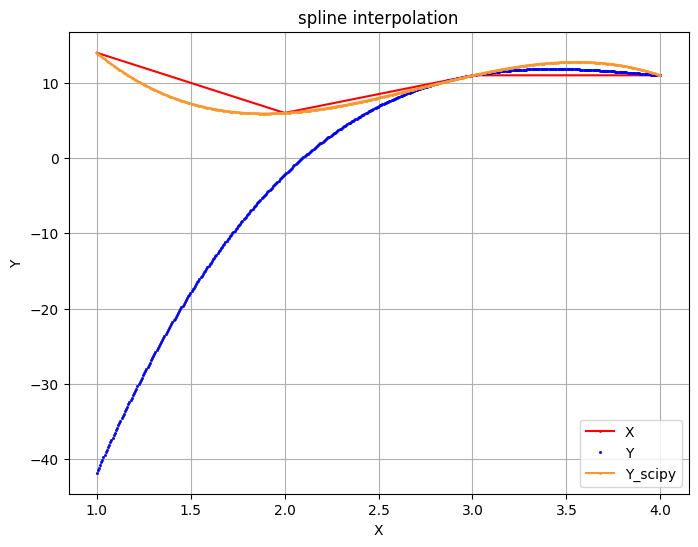

In [845]:
Y = my_interp_plotter(x,y,X,'spline')